## Merging Files

In [2]:
import csv

# Generate filenames programmatically
path = "/Volumes/T9/XGBoost_OD_TBBE/XGBoostTBBE/1000simXgb1_2000mData"
files = [path + "/getXGBoostTrainingData_{}.csv".format(i) for i in range(1000)]

merged_filename = "/Volumes/T9/XGBoost_OD_TBBE/XGBoostTraining/dataXgb2_2000mNoStack/XGB_merged_result.csv"

with open(merged_filename, "w", newline="") as outfile:
    writer = csv.writer(outfile)

    for index, filename in enumerate(files):
        with open(filename, "r") as infile:
            reader = csv.reader(infile)

            # Skip header only if it's not the first file
            if index != 0:
                next(reader, None)

            # Write rows from current file to the output file
            writer.writerows(reader)

## Sorting values by balance

In [3]:
import pandas as pd

# Read the merged CSV file into a DataFrame
df = pd.read_csv(
    "/Volumes/T9/XGBoost_OD_TBBE/XGBoostTraining/dataXgb2_2000mNoStack/XGB_merged_result.csv"
)

# Sort the DataFrame by balance in descending order
df_sorted = df.sort_values(by="balance", ascending=False)

df_sorted.head(100)

,type,competitorID,time,exchange,odds,agentID,stake,distance,rank,balance,decision
3392761,Trade,4,6.904874,0,3.484536,51,15,75.392348,1,1.000458e+08,layer
3398533,Trade,4,175.244816,0,1.553899,51,15,1873.859365,2,1.000458e+08,layer
3398493,Trade,4,175.204799,0,1.845313,51,15,1873.859365,2,1.000458e+08,layer
3398495,Trade,4,175.205239,0,1.845313,51,15,1873.859365,2,1.000458e+08,layer
3398501,Trade,4,175.206148,0,1.845313,51,15,1873.859365,2,1.000458e+08,layer
...,...,...,...,...,...,...,...,...,...,...,...
3398611,Trade,4,175.289687,0,1.553899,51,15,1873.859365,2,1.000458e+08,layer
3398619,Trade,4,175.291981,0,1.553899,51,15,1873.859365,2,1.000458e+08,layer
3398621,Trade,4,175.292620,0,1.553899,51,15,1873.859365,2,1.000458e+08,layer
3398623,Trade,4,175.293492,0,1.553899,51,15,1873.859365,2,1.000458e+08,layer


## Saving top 20% of values for training

In [4]:
# Calculate 20% of the total number of rows and retrieve the top rows
top_20_percent = int(0.20 * len(df_sorted))
top_20_df = df_sorted.head(top_20_percent)

# Save the top 20% rows to a new CSV file, if desired
top_20_df.to_csv(
    "/Volumes/T9/XGBoost_OD_TBBE/XGBoostTraining/dataXgb2_2000mNoStack/XGB_Top_20%.csv",
    index=False,
)

## Pre-processing and splitting of data

In [6]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 1. Import the data
data = pd.read_csv(
    "/Volumes/T9/XGBoost_OD_TBBE/XGBoostTraining/dataXgb2_2000mNoStack/XGB_Top_20%.csv"
)
decision_counts = data["decision"].value_counts()
print(decision_counts)


# Remove potentially irrelevant columns
data = data.drop(
    columns=["type", "competitorID", "exchange", "agentID", "balance", "odds"]
)

# Column that has left: time  odds  stake  distance  rank

# Convert 'decision' column to binary: 1 for 'backer' and 0 for 'layer'
data["decision"] = data["decision"].map({"backer": 1, "layer": 0})

# Split data into training and testing sets
X = data.drop(columns="decision")
print(X.head())
y = data["decision"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

decision
layer     1832635
backer     455201
Name: count, dtype: int64
         time  stake     distance  rank
0    6.904874     15    75.392348     1
1  175.244816     15  1873.859365     2
2  175.204799     15  1873.859365     2
3  175.205239     15  1873.859365     2
4  175.206148     15  1873.859365     2


## Model Training

In [7]:
from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report


# Define the function to optimize
def bo_tune_xgb(eta, max_depth, subsample, colsample_bytree, gamma, alpha, lambda_):
    params = {
        "eta": eta,
        "max_depth": int(max_depth),
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "gamma": gamma,
        "alpha": alpha,
        "lambda": lambda_,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "n_estimators": 100,
        "random_state": 42,
    }
    cv_result = xgb.cv(params, dtrain, nfold=5)
    y_pred = xgb.train(params, dtrain, num_boost_round=100).predict(xgb.DMatrix(X_test))
    y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]  # Apply threshold
    return accuracy_score(y_test, y_pred)


# Convert training data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)

# Define the bounds of the hyperparameters to optimize
hyperparameter_space = {
    "eta": (0.1, 0.6),
    "max_depth": (5, 8),
    "subsample": (0.5, 1.0),
    "colsample_bytree": (0.5, 1.0),
    "gamma": (0, 0.4),
    "alpha": (0, 2.0),
    "lambda_": (0, 3.0),
}

# Initialize Bayesian optimizer
optimizer = BayesianOptimization(
    f=bo_tune_xgb, pbounds=hyperparameter_space, random_state=42, verbose=2
)

# Perform optimization
optimizer.maximize(init_points=5, n_iter=50)

# Print best parameters and score
print("Best parameters found:", optimizer.max["params"])
print("Best cross-validation score:", optimizer.max["target"])

# Use the best model for prediction and evaluation
best_params = optimizer.max["params"]
best_params["max_depth"] = int(best_params["max_depth"])
best_model = xgb.train(best_params, dtrain, num_boost_round=100)

y_pred_best = best_model.predict(xgb.DMatrix(X_test))
y_pred_best = [1 if pred > 0.5 else 0 for pred in y_pred_best]  # Apply threshold
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Accuracy (Best Model):", accuracy_best)
print(classification_report(y_test, y_pred_best))

|   iter    |  target   |   alpha   | colsam... |    eta    |   gamma   |  lambda_  | max_depth | subsample |
-------------------------------------------------------------------------------------------------------------


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:09:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:09:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:09:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:09:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 1         | 0.823     | 0.7491    | 0.9754    | 0.466     | 0.2395    | 0.4681    | 5.468     | 0.529     |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:10:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:10:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:10:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 2         | 0.8362    | 1.732     | 0.8006    | 0.454     | 0.008234  | 2.91      | 7.497     | 0.6062    |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:10:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:10:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:10:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:10:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 3         | 0.8122    | 0.3636    | 0.5917    | 0.2521    | 0.2099    | 1.296     | 5.874     | 0.8059    |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:10:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:10:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:11:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 4         | 0.8131    | 0.279     | 0.6461    | 0.2832    | 0.1824    | 2.356     | 5.599     | 0.7571    |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:11:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:11:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:11:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:11:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 5         | 0.8236    | 1.185     | 0.5232    | 0.4038    | 0.06821   | 0.1952    | 7.847     | 0.9828    |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:11:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:11:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:11:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:11:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 6         | 0.8545    | 2.0       | 1.0       | 0.6       | 0.4       | 3.0       | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:12:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:12:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:12:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:12:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 7         | 0.8559    | 2.0       | 1.0       | 0.6       | 0.4       | 2.088     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:12:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:12:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:12:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 8         | 0.8553    | 0.0       | 1.0       | 0.6       | 0.4       | 3.0       | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:12:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:12:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:13:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 9         | 0.833     | 0.8906    | 1.0       | 0.1       | 0.4       | 2.426     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:13:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:13:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:13:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:13:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 10        | 0.8304    | 0.0       | 0.5       | 0.6       | 0.4       | 3.0       | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:13:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:13:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:13:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:13:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 11        | 0.8496    | 2.0       | 1.0       | 0.6       | 0.4       | 2.044     | 7.204     | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:14:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:14:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:14:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 12        | 0.8528    | 2.0       | 1.0       | 0.6       | 0.4       | 1.372     | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:14:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:14:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:14:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 13        | 0.8165    | 2.0       | 0.5       | 0.1       | 0.4       | 1.909     | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:15:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:15:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:15:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:15:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 14        | 0.8244    | 1.953     | 0.8499    | 0.5514    | 0.1779    | 1.224     | 5.721     | 0.5895    |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:15:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:15:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:15:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 15        | 0.8207    | 0.8566    | 0.6636    | 0.3588    | 0.3926    | 0.05051   | 7.672     | 0.7597    |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:15:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:15:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:15:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 16        | 0.8509    | 2.0       | 1.0       | 0.6       | 0.4       | 1.275     | 7.616     | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:16:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:16:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:16:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:16:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 17        | 0.8571    | 2.0       | 1.0       | 0.6       | 0.0       | 1.582     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:16:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:16:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:16:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 18        | 0.8506    | 0.0       | 1.0       | 0.6       | 0.4       | 3.0       | 7.159     | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:16:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:16:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:16:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:17:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 19        | 0.8569    | 0.0       | 1.0       | 0.6       | 0.0       | 2.038     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:17:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:17:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:17:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:17:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 20        | 0.8574    | 0.0       | 1.0       | 0.6       | 0.0       | 1.129     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:17:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:17:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:17:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:17:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 21        | 0.8576    | 0.9096    | 1.0       | 0.6       | 0.0       | 1.459     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:18:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:18:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:18:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:18:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 22        | 0.8314    | 2.0       | 1.0       | 0.6       | 0.0       | 3.0       | 5.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:18:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:18:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:18:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:18:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 23        | 0.8534    | 0.0       | 1.0       | 0.6       | 0.0       | 1.42      | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:19:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:19:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:19:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 24        | 0.8493    | 0.0       | 1.0       | 0.6       | 0.0       | 1.568     | 7.377     | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:19:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:19:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:19:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 25        | 0.8563    | 0.0       | 1.0       | 0.6       | 0.4       | 1.556     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:19:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:19:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:20:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 26        | 0.8567    | 1.457     | 1.0       | 0.6       | 0.0       | 2.107     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:20:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:20:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:20:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:20:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 27        | 0.8568    | 0.6319    | 1.0       | 0.6       | 0.0       | 3.0       | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:20:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:20:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:20:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 28        | 0.8493    | 0.0       | 1.0       | 0.6       | 0.0       | 3.0       | 7.767     | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:21:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:21:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:21:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 29        | 0.8498    | 1.014     | 1.0       | 0.6       | 0.4       | 3.0       | 7.492     | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:21:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:21:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:21:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 30        | 0.8533    | 2.0       | 1.0       | 0.6       | 0.0       | 0.6369    | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:21:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:21:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:21:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:22:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 31        | 0.8565    | 2.0       | 1.0       | 0.6       | 0.0       | 2.574     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:22:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:22:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:22:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 32        | 0.857     | 0.389     | 1.0       | 0.6       | 0.0       | 1.655     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:22:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:22:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:22:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:22:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 33        | 0.8545    | 1.362     | 1.0       | 0.6       | 0.0       | 1.217     | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:23:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:23:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:23:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 34        | 0.8551    | 0.0       | 1.0       | 0.6       | 0.0       | 0.3768    | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:23:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:23:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:23:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:23:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 35        | 0.8577    | 0.0       | 1.0       | 0.6       | 0.0       | 0.0       | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:24:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:24:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:24:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:24:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 36        | 0.8329    | 0.0       | 1.0       | 0.1       | 0.0       | 0.2429    | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:24:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:24:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:24:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 37        | 0.8554    | 0.3343    | 1.0       | 0.6       | 0.4       | 2.428     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:24:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:24:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:24:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:25:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 38        | 0.8497    | 0.0       | 1.0       | 0.6       | 0.0       | 0.0       | 7.168     | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:25:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:25:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:25:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 39        | 0.8559    | 0.0       | 1.0       | 0.6       | 0.4       | 0.4326    | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:25:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:25:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:25:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:25:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 40        | 0.8541    | 0.0       | 1.0       | 0.6       | 0.4       | 0.0       | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:26:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:26:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:26:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:26:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 41        | 0.8564    | 1.374     | 1.0       | 0.6       | 0.0       | 3.0       | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:26:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:26:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:26:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 42        | 0.8579    | 1.56      | 1.0       | 0.6       | 0.0       | 1.157     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:26:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:26:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:26:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 43        | 0.8542    | 1.374     | 1.0       | 0.6       | 0.4       | 1.475     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:27:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:27:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:27:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:27:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 44        | 0.8538    | 0.7814    | 1.0       | 0.6       | 0.4       | 3.0       | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:27:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:27:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:27:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:27:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 45        | 0.8577    | 2.0       | 1.0       | 0.6       | 0.0       | 0.9206    | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:27:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:27:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:27:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:28:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 46        | 0.8578    | 0.5949    | 1.0       | 0.6       | 0.0       | 0.9189    | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:28:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:28:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:28:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:28:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 47        | 0.8579    | 2.0       | 1.0       | 0.6       | 0.0       | 0.0       | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:28:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:28:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:28:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 48        | 0.8587    | 2.0       | 1.0       | 0.6       | 0.4       | 0.0       | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:29:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:29:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:29:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:29:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 49        | 0.8541    | 2.0       | 1.0       | 0.6       | 0.4       | 0.5197    | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:29:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:29:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:29:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 50        | 0.85      | 2.0       | 1.0       | 0.6       | 0.0       | 0.0       | 7.083     | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:29:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:29:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:29:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:29:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 51        | 0.8319    | 2.0       | 1.0       | 0.6       | 0.0       | 0.0       | 5.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:30:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:30:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:30:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:30:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 52        | 0.8571    | 0.8434    | 1.0       | 0.6       | 0.0       | 2.493     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:30:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:30:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:30:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 53        | 0.8575    | 0.0       | 1.0       | 0.6       | 0.0       | 0.5403    | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:30:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:30:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:30:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:31:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 54        | 0.8496    | 2.0       | 1.0       | 0.6       | 0.0       | 3.0       | 7.101     | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:31:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:31:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:31:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:31:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 55        | 0.8543    | 0.0       | 1.0       | 0.6       | 0.4       | 0.8953    | 8.0       | 0.5       |
Best parameters found: {'alpha': 2.0, 'colsample_bytree': 1.0, 'eta': 0.6, 'gamma': 0.4, 'lambda_': 0.0, 'max_depth': 8.0, 'subsample': 1.0}
Best cross-validation score: 0.85872700888174


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:31:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy (Best Model): 0.8384349430030072
              precision    recall  f1-score   support

           0       0.85      0.98      0.91    366266
           1       0.74      0.29      0.42     91302

    accuracy                           0.84    457568
   macro avg       0.80      0.63      0.66    457568
weighted avg       0.83      0.84      0.81    457568



## Boxplot of parameters


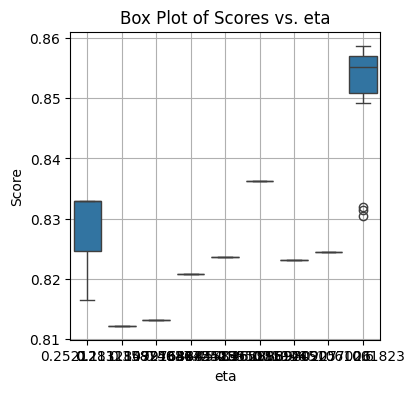

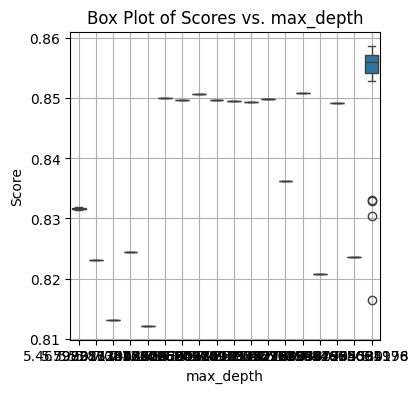

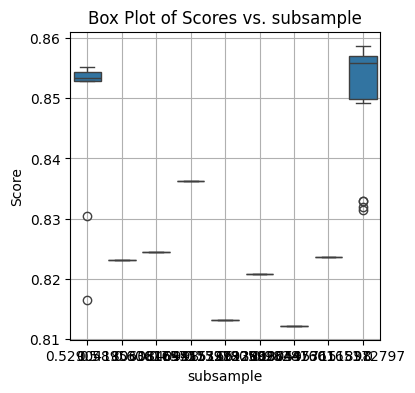

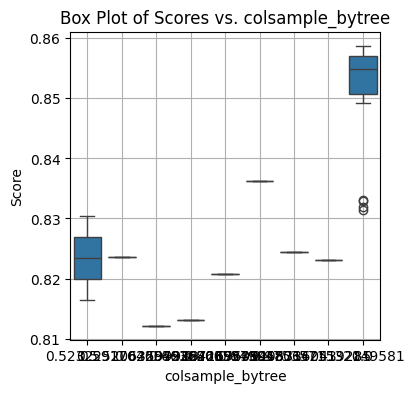

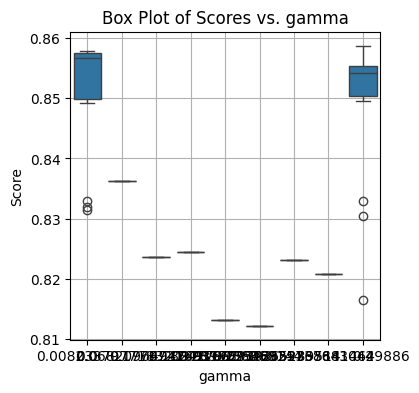

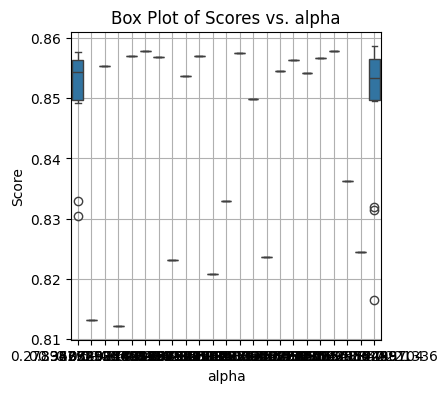

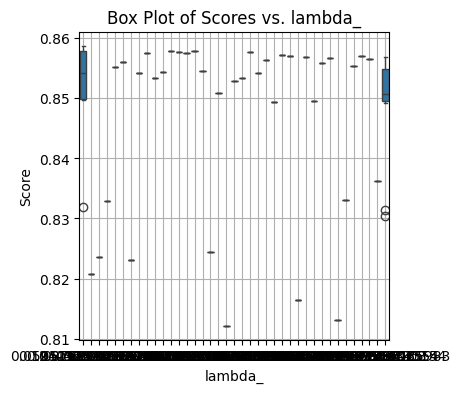

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert the optimization results to a dataframe
results_df = pd.DataFrame(optimizer.res)

# Extract the parameters into separate columns
for param in hyperparameter_space.keys():
    results_df[param] = results_df["params"].apply(lambda params: params[param])

# Melt the dataframe for seaborn
melted_scores_df = results_df.melt(
    id_vars=list(hyperparameter_space.keys()),
    value_vars=["target"],
    var_name="iteration",
    value_name="score",
)

for param in hyperparameter_space.keys():
    plt.figure(figsize=(4, 4))

    # Boxplot
    sns.boxplot(data=melted_scores_df, x=param, y="score")
    plt.title(f"Box Plot of Scores vs. {param}")
    plt.ylabel("Score")
    plt.grid(True)
    plt.show()

## Model evaluation and performance visualisation 

Accuracy: 0.8384349430030072

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91    366266
           1       0.74      0.29      0.42     91302

    accuracy                           0.84    457568
   macro avg       0.80      0.63      0.66    457568
weighted avg       0.83      0.84      0.81    457568



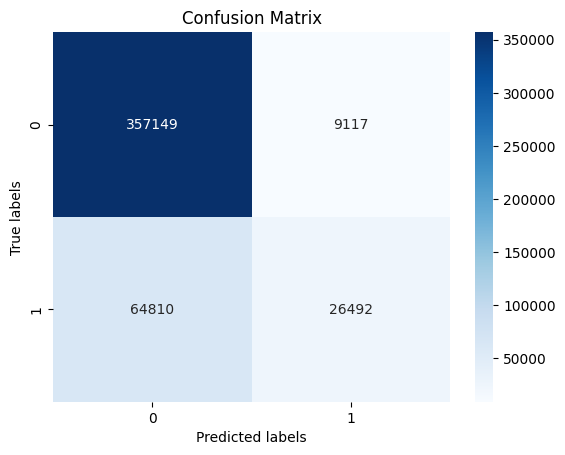

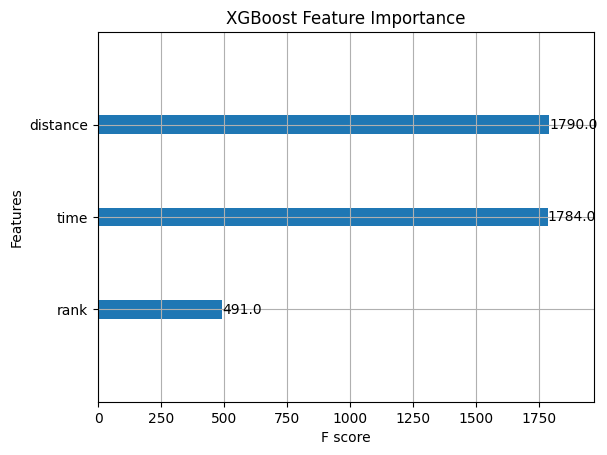

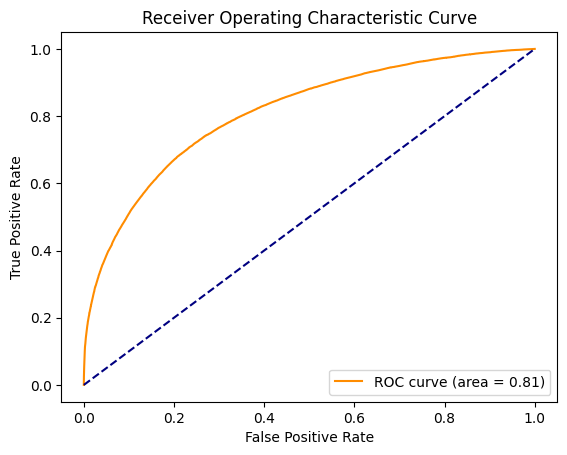

PR AUC: 0.5871876169754924


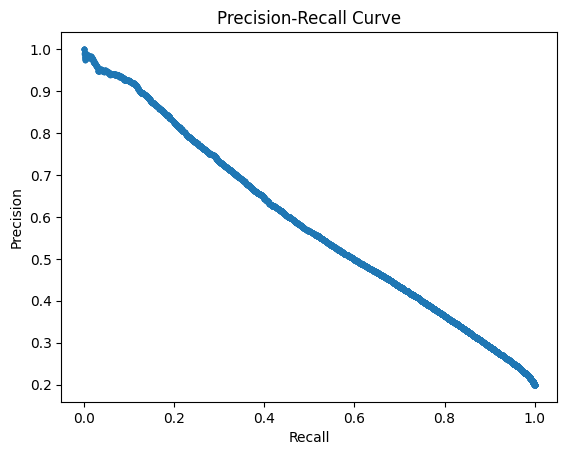

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
)
import seaborn as sns
import joblib

# 1. Testing on the Test Set
y_pred = y_pred_best

# 2. Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

# 3. Visualization

# Feature Importance
xgb.plot_importance(best_model)
plt.title("XGBoost Feature Importance")
plt.show()

# ROC Curve
y_pred_proba = best_model.predict(xgb.DMatrix(X_test))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color="darkorange", label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, marker=".")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
# Compute and print AUC for Precision-Recall Curve
pr_auc = auc(recall, precision)
print(f"PR AUC: {pr_auc}")
plt.show()

## Train-test error progression plot

Best parameters found: {'alpha': 2.0, 'colsample_bytree': 1.0, 'eta': 0.6, 'gamma': 0.4, 'lambda_': 0.0, 'max_depth': 8, 'subsample': 1.0}


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:34:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


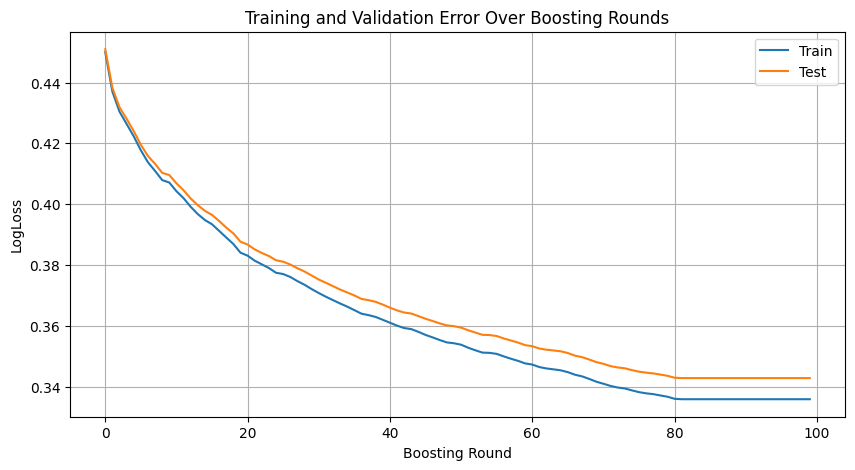

In [11]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Use the best parameters from the Bayesian optimization
print("Best parameters found:", best_params)

# Convert the booster to scikit-learn format using best parameters
best_xgb_estimator = xgb.XGBClassifier(
    objective="binary:logistic", random_state=42, n_estimators=100, **best_params
)

# Evaluate the model's performance on train and test datasets during training
eval_set = [(X_train, y_train), (X_test, y_test)]
best_xgb_estimator.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# Extract and plot the training and test logloss over boosting rounds
results = best_xgb_estimator.evals_result()
train_errors = results["validation_0"]["logloss"]
test_errors = results["validation_1"]["logloss"]

plt.figure(figsize=(10, 5))
plt.plot(train_errors, label="Train")
plt.plot(test_errors, label="Test")
plt.xlabel("Boosting Round")
plt.ylabel("LogLoss")
plt.title("Training and Validation Error Over Boosting Rounds")
plt.legend()
plt.grid(True)
plt.show()

## N_Estimators and Early stopping

In [12]:
# Convert the booster to scikit-learn format using best parameters
best_xgb_estimator = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_estimators=2000,  # Increasing n_estimators to 2000
    **best_params
)

# Evaluate the model's performance on train and test datasets during training
eval_set = [(X_train, y_train), (X_test, y_test)]
best_xgb_estimator.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    early_stopping_rounds=20,  # Increasing early stopping rounds to 20
    verbose=False,
)

/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:34:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(alpha=2.0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.6, eval_metric='logloss',
              feature_types=None, gamma=0.4, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda_=0.0,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=2000, ...)

/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:35:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


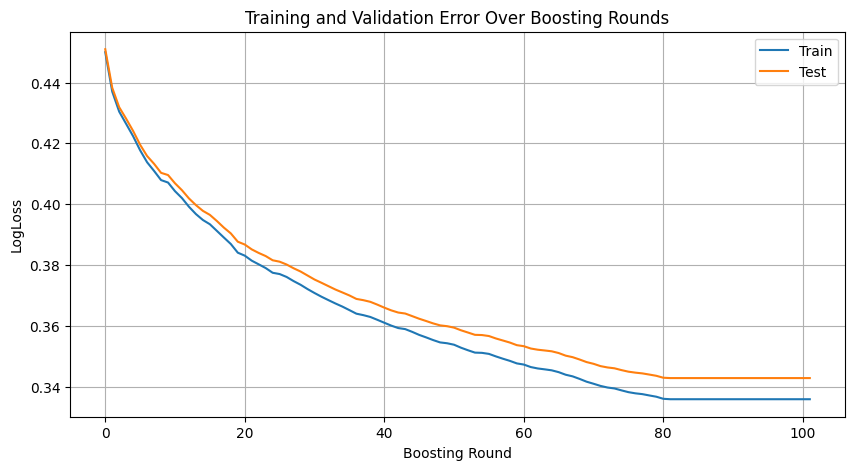

In [13]:
# Evaluate the model's performance on train and test datasets during training
eval_set = [(X_train, y_train), (X_test, y_test)]
best_xgb_estimator.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    early_stopping_rounds=20,  # Increasing early stopping rounds to 20
    verbose=False,
)

# Extract and plot the training and test logloss over boosting rounds
results = best_xgb_estimator.evals_result()
train_errors = results["validation_0"]["logloss"]
test_errors = results["validation_1"]["logloss"]

plt.figure(figsize=(10, 5))
plt.plot(train_errors, label="Train")
plt.plot(test_errors, label="Test")
plt.xlabel("Boosting Round")
plt.ylabel("LogLoss")
plt.title("Training and Validation Error Over Boosting Rounds")
plt.legend()
plt.grid(True)
plt.show()

/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:35:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


Best iteration: 81


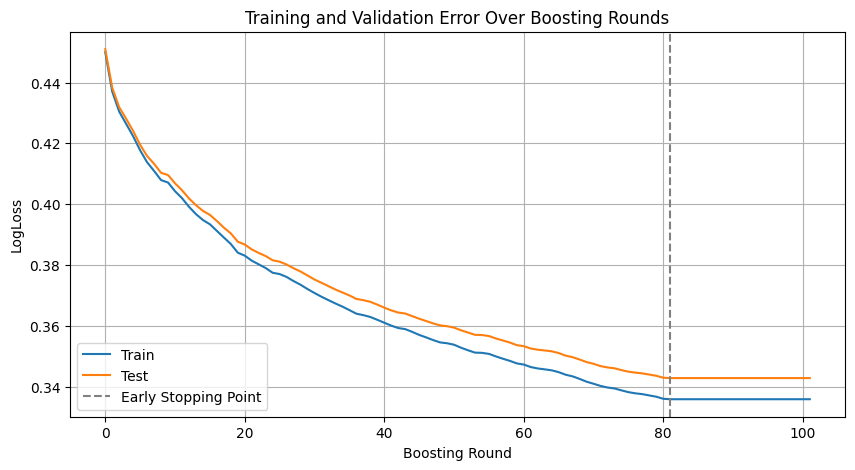

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.79069 to fit


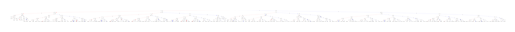

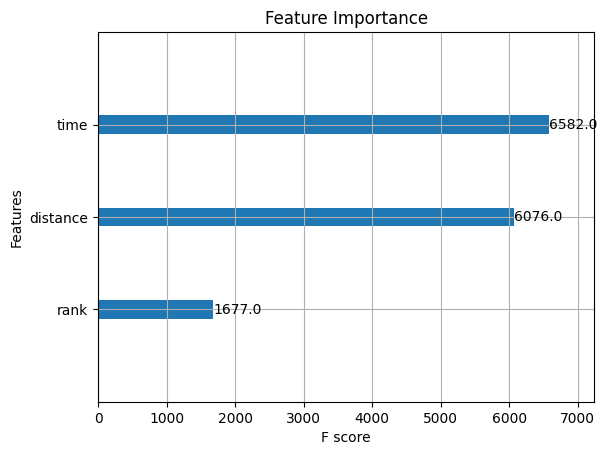

    Feature  Importance
3      rank    0.574201
2  distance    0.217601
0      time    0.208198
1     stake    0.000000


In [14]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Convert the booster to scikit-learn format using best parameters
best_xgb_estimator = xgb.XGBClassifier(
    objective="binary:logistic",
    random_state=42,
    n_estimators=2000,  # Increasing n_estimators to 2000
    **best_params,
)

# Evaluate the model's performance on train and test datasets during training
eval_set = [(X_train, y_train), (X_test, y_test)]
best_xgb_estimator.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    early_stopping_rounds=20,  # Increasing early stopping rounds to 20
    verbose=False,
)

# 1. Print the boosting round where early stopping occurred:
print(f"Best iteration: {best_xgb_estimator.get_booster().best_iteration}")

# Extract and plot the training and test logloss over boosting rounds
results = best_xgb_estimator.evals_result()
train_errors = results["validation_0"]["logloss"]
test_errors = results["validation_1"]["logloss"]

plt.figure(figsize=(10, 5))
plt.plot(train_errors, label="Train")
plt.plot(test_errors, label="Test")
plt.axvline(
    x=best_xgb_estimator.get_booster().best_iteration,
    color="gray",
    linestyle="--",
    label="Early Stopping Point",
)
plt.xlabel("Boosting Round")
plt.ylabel("LogLoss")
plt.title("Training and Validation Error Over Boosting Rounds")
plt.legend()
plt.grid(True)
plt.show()

# 2. Visualize the model using XGBoost's plot functionalities:

# a. Plotting the first tree:
xgb.plot_tree(best_xgb_estimator, num_trees=0)
plt.show()

# b. Displaying the importance of each feature:
xgb.plot_importance(best_xgb_estimator)
plt.title("Feature Importance")
plt.show()

# Feature importances:
importances = best_xgb_estimator.feature_importances_
features = X_train.columns
feature_importance_df = pd.DataFrame(
    {"Feature": features, "Importance": importances}
).sort_values(by="Importance", ascending=False)
print(feature_importance_df)

In [1]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict the classes
y_pred = best_xgb_estimator.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

# Visualizing the Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

# Precision, recall, f1-score plots for each class
precision, recall, f1score, _ = precision_recall_fscore_support(
    y_test, y_pred, average=None
)

plt.figure(figsize=(12, 4))

plt.subplot(131)
sns.barplot(x=np.unique(y_test), y=precision)
plt.title("Precision scores")
plt.xlabel("Classes")
plt.ylabel("Precision")

plt.subplot(132)
sns.barplot(x=np.unique(y_test), y=recall)
plt.title("Recall scores")
plt.xlabel("Classes")
plt.ylabel("Recall")

plt.subplot(133)
sns.barplot(x=np.unique(y_test), y=f1score)
plt.title("F1 scores")
plt.xlabel("Classes")
plt.ylabel("F1 score")

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

## Saving the model


In [17]:
# Save the best model to a .json file
best_model.save_model("Trained_XGB2_model.json")